# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [65]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [66]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [67]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

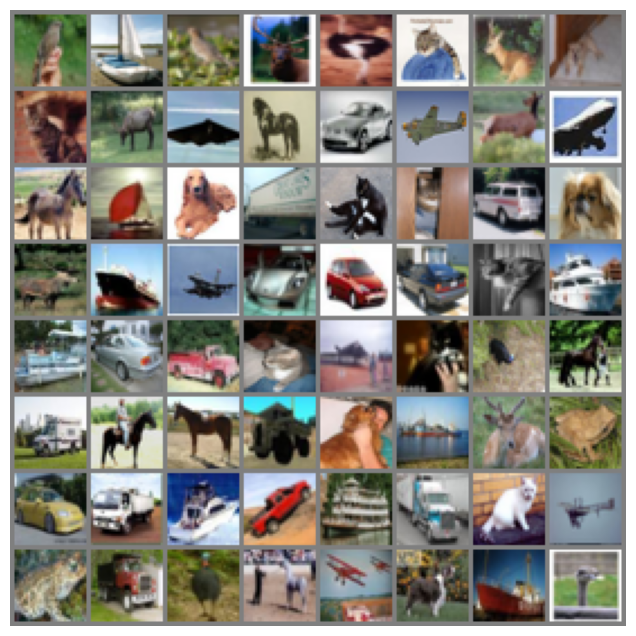

In [68]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [69]:
torch.cuda.is_available()

False

In [70]:
import torch
import torch.nn as nn

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # Define your layers here
        self.net = nn.Sequential(
            PrintSize(),
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),  # Conv layer (input: RGB images)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Pooling layer
            PrintSize(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # Conv layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Pooling layer
            PrintSize(),
            nn.Flatten(),  # Flatten the output for the fully connected layers
            nn.Linear(32 * 8 * 8, 128),  # Linear layer (adjust the size based on the input image size)
            nn.ReLU(),
            nn.Linear(128, num_classes)  # Output layer with `num_classes` as the final output size
        )

    def forward(self, x):
        # Forward pass through the network
        return self.net(x)


# Initialize the model
n_classes = 10  # Define the number of classes for the output
model = Model(n_classes)

# Move the model to the specified device (CPU or GPU)
device = torch.device('cpu') # Change to 'cuda' if you have a GPU available
model.to(device)

# Print the model architecture
print(model)


Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): PrintSize()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): PrintSize()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [72]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Size: torch.Size([2, 3, 32, 32])
Size: torch.Size([2, 16, 16, 16])
Size: torch.Size([2, 32, 8, 8])
Output shape: torch.Size([2, 10])
Output logits:
[[ 0.05900141  0.01974811  0.10182711 -0.08967977  0.00823083 -0.10676783
   0.12773046 -0.04955611 -0.0615735  -0.06874932]
 [ 0.03125331  0.0780327   0.08970076 -0.13230705  0.02855053 -0.11248841
   0.14429191 -0.02332245 -0.0552752  -0.07089003]]
Output probabilities:
[[0.10638748 0.10229232 0.11104257 0.09168939 0.10112095 0.09013591
  0.11395652 0.09544311 0.094303   0.09362872]
 [0.10301654 0.10795008 0.10921703 0.08747292 0.10273848 0.0892238
  0.11534506 0.097545   0.09447744 0.09301364]]


In [73]:
num_epochs = 2
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()  # Clear gradients from previous step
        output = model(inputs)  # Compute the model's predictions

        # Loss calculation
        loss = loss_fn(output, targets)  # Calculate loss based on predictions and targets

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        # Increment step counter
        step += 1

        # Compute training accuracy
        predictions = output.max(1)[1]  # Get the index of the highest logit as predictions
        train_accuracies_batches.append(accuracy(targets, predictions))  # Track accuracy for this batch

        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))  # Compute the average accuracy for this interval
            train_accuracies_batches = []  # Reset for the next batch interval
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():  # Disable gradient computation for validation
                model.eval()  # Set model to evaluation mode (disables dropout, batchnorm, etc.)
                
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)  # Forward pass for validation
                    loss = loss_fn(output, targets)  # Compute validation loss (optional)

                    predictions = output.max(1)[1]  # Get predictions
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))  # Multiply accuracy by batch size
                
                model.train()  # Set model back to training mode

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_loader.dataset))  # Normalize by dataset size
     
            # Print accuracies
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             validation accuracy: {valid_accuracies[-1]:.4f}")

print("Finished training.")

Step 500     training accuracy: 0.4370
             validation accuracy: 0.5249
Step 1000    training accuracy: 0.5787
             validation accuracy: 0.5846
Step 1500    training accuracy: 0.6165
             validation accuracy: 0.5982
Finished training.


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

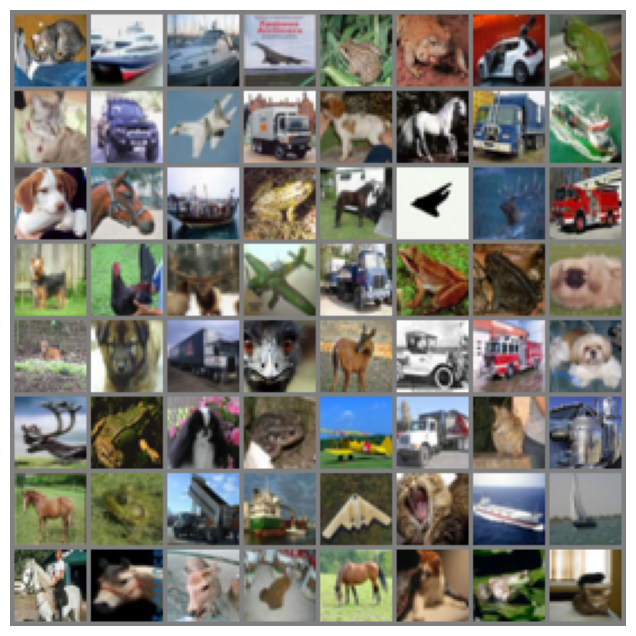

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship       automobile  
    ship        airplane   
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          deer     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          bird     
    truck         truck    
     dog          deer     
    bird          deer     
    deer          deer     
  airplane        bird     
    truck         truck    
    frog          frog     
    frog          frog     
     dog          bird     
    deer          bird     
     dog           c

In [74]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [75]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [76]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.616


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


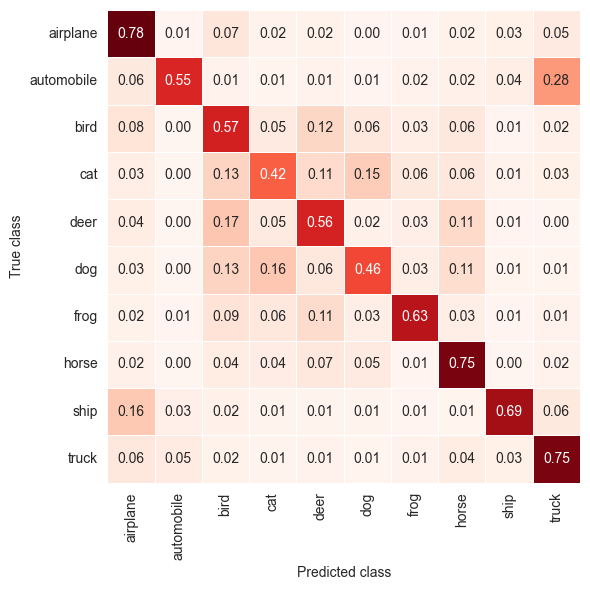

In [77]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

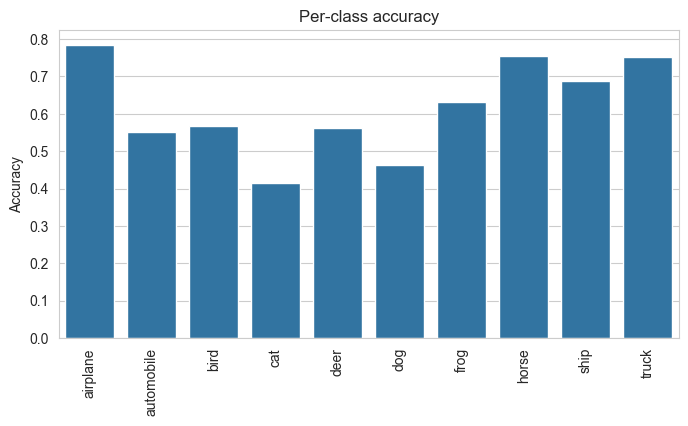

In [78]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

No, it taking alot of time to test with additonal layers.

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

I added a second convolutional layer and a pooling layer to the model to allow it to learn more complex features. I also observed that adding layers and increasing complexity (like adding more filters and layers) often leads to better performance on image classification tasks.     
Observed Intitally low but exponentail rise in learning rate with sigmoid.

3. Write down key lessons/insights you got during this exercise.

The choice of activation function can greatly influence learning. So try test functions for better understanding.



# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [79]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).
To prove:   
$$ \sigma(z) = \frac{1}{1+e^{-z}} = (1+e^{-z})^{-1} $$

**Answer:** 
Differentiating the function using the chain vrule:
$$
\begin{align}
\frac{d}{dz}(\sigma(z)) &= - \frac{1}{(1+e^{-z})^2} (1+e^{-z}) \\
&= - \frac{1}{(1+e^{-z})^2} (-e^{-z}) \\
&= \frac{e^{-z}}{(1+e^{-z})^2}
\end{align}
$$
Which is 
$$ \sigma'(z) = \sigma(z)(1-\sigma(z)) $$
Following the expression 
$$
\begin{align}
\frac{e^{-z}}{(1+e^{-z})^2} &= (\frac{1}{1+e^{-z}})(1-\frac{1}{1+e^{-z}}) \\
e^{-z} &= (\frac{1}{1+e^{-z}})(1-\frac{1}{1+e^{-z}}) (1+e^{-z})^2 \\
e^{-z} &= (\frac{(1+e^{-z})^2}{1+e^{-z}})(1-\frac{1}{1+e^{-z}}) \\
e^{-z} &= ((1+e^{-z})-1) \\
e^{-z} &= 1+e^{-z}-1 \\
e^{-z} &= e^{-z} \\
\end{align}
$$
Hence proved
